<a href="https://colab.research.google.com/github/Praveen76/Employee-Attrition-Mini-Project/blob/main/Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip -qq install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import json
import os

# Set the Kaggle API key path
kaggle_key_path = '/content/drive/MyDrive/DS_Learning/.kaggle/kaggle.json'
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/DS_Learning/.kaggle'

# Check if the key is correctly set
with open(kaggle_key_path, 'r') as kaggle_key_file:
    kaggle_key_data = json.load(kaggle_key_file)
    print(f'Kaggle API username: {kaggle_key_data["username"]}')


Kaggle API username: praveen7851


In [ ]:
!kaggle datasets download -d pavansubhasht/ibm-hr-analytics-attrition-dataset

  0% 0.00/50.1k [00:00<?, ?B/s]
100% 50.1k/50.1k [00:00<00:00, 78.0MB/s]


In [ ]:
#import zipfile module
from zipfile import ZipFile

with ZipFile('ibm-hr-analytics-attrition-dataset.zip', 'r') as f:
  #extract in current directory
  f.extractall()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

In [ ]:
ibm_df = pd.read_csv('/content/WA_Fn-UseC_-HR-Employee-Attrition.csv')
ibm_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
ibm_df.shape

(1470, 35)

In [ ]:
ibm_df.Over18.value_counts()

Y    1470
Name: Over18, dtype: int64

In [ ]:
ibm_df.EmployeeCount.value_counts()

1    1470
Name: EmployeeCount, dtype: int64

In [ ]:
ibm_df = ibm_df.drop(['EmployeeNumber', 'EmployeeCount','Over18'], axis=1)
ibm_df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,80,1,6,3,3,2,2,2,2


In [ ]:
# Shape of dataframe
ibm_df.shape

(1470, 32)

In [ ]:
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in ibm_df.columns:
    obs = ibm_df[col].size
    p_nan = round(ibm_df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({ibm_df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if ibm_df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(ibm_df[col].unique())} labels' if dtype == 'categorical' else f'{ibm_df[col].min()}-{ibm_df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

#numerical.remove('employeecount')
numerical.remove('StandardHours')
pd.set_option('display.max_columns', 100)
display(description)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
observations(rows),1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
percent missing,0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,18-60,2 labels,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,2 labels,11-25,3-4,1-4,80-80,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17


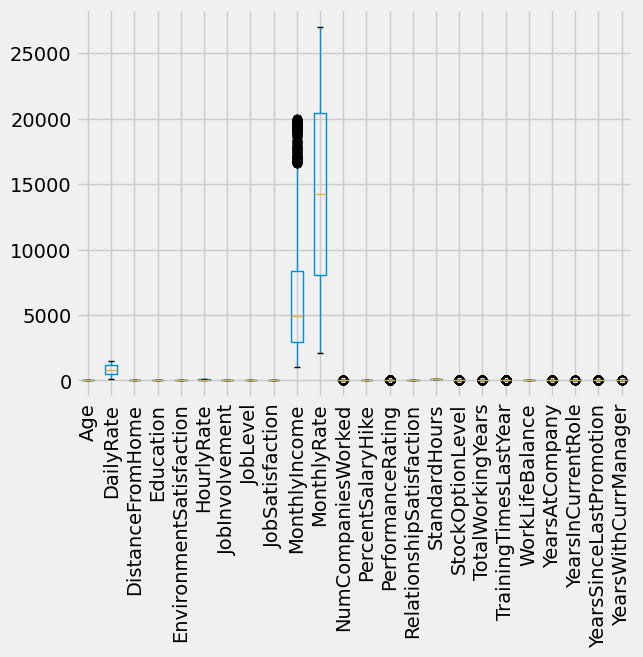

In [ ]:
# Check for outliers
ibm_df.boxplot(rot = 90)
plt.show()

In [ ]:
# Handing outliers
# Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]

In [ ]:
outlier_colms = ['MonthlyIncome', 'NumCompaniesWorked', 'StockOptionLevel',  'PerformanceRating', 'TotalWorkingYears',
                 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
ibm_df1 = ibm_df.copy()

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

for colm in outlier_colms:
    ibm_df1 = handle_outliers(ibm_df1, colm)

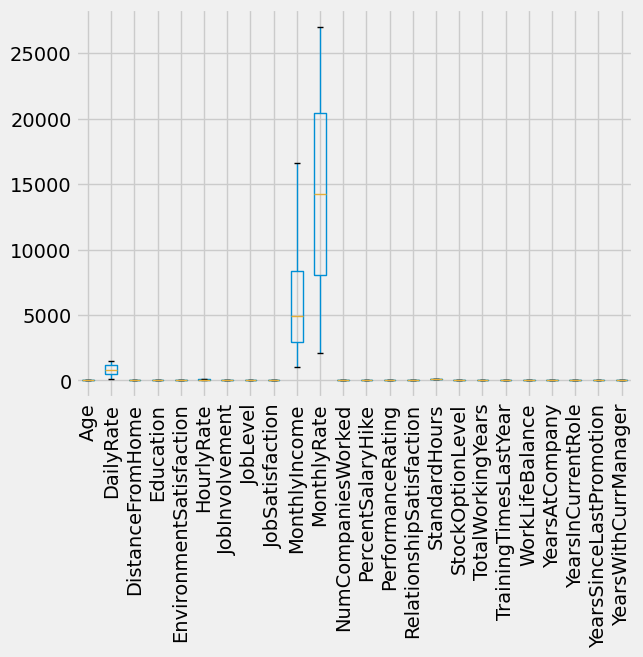

In [ ]:
# Recheck for outliers
ibm_df1.boxplot(rot = 90)
plt.show()

In [ ]:
#Check if it's an imbalance dataset
# Count of unique values in Attrition column
attrition_values = ibm_df1['Attrition'].value_counts()
attrition_values

No     1233
Yes     237
Name: Attrition, dtype: int64

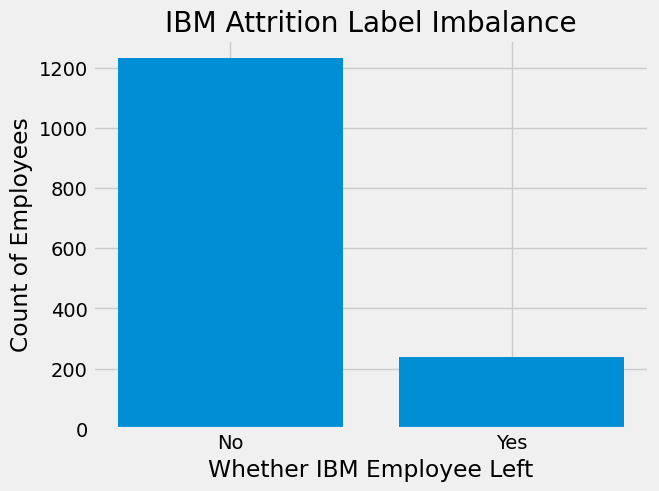

In [ ]:
# Plot barplot
plt.bar(attrition_values.index, attrition_values.values)
plt.title('IBM Attrition Label Imbalance')
plt.xlabel('Whether IBM Employee Left')
plt.ylabel('Count of Employees')
plt.show()

In [ ]:
ibm_df1.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

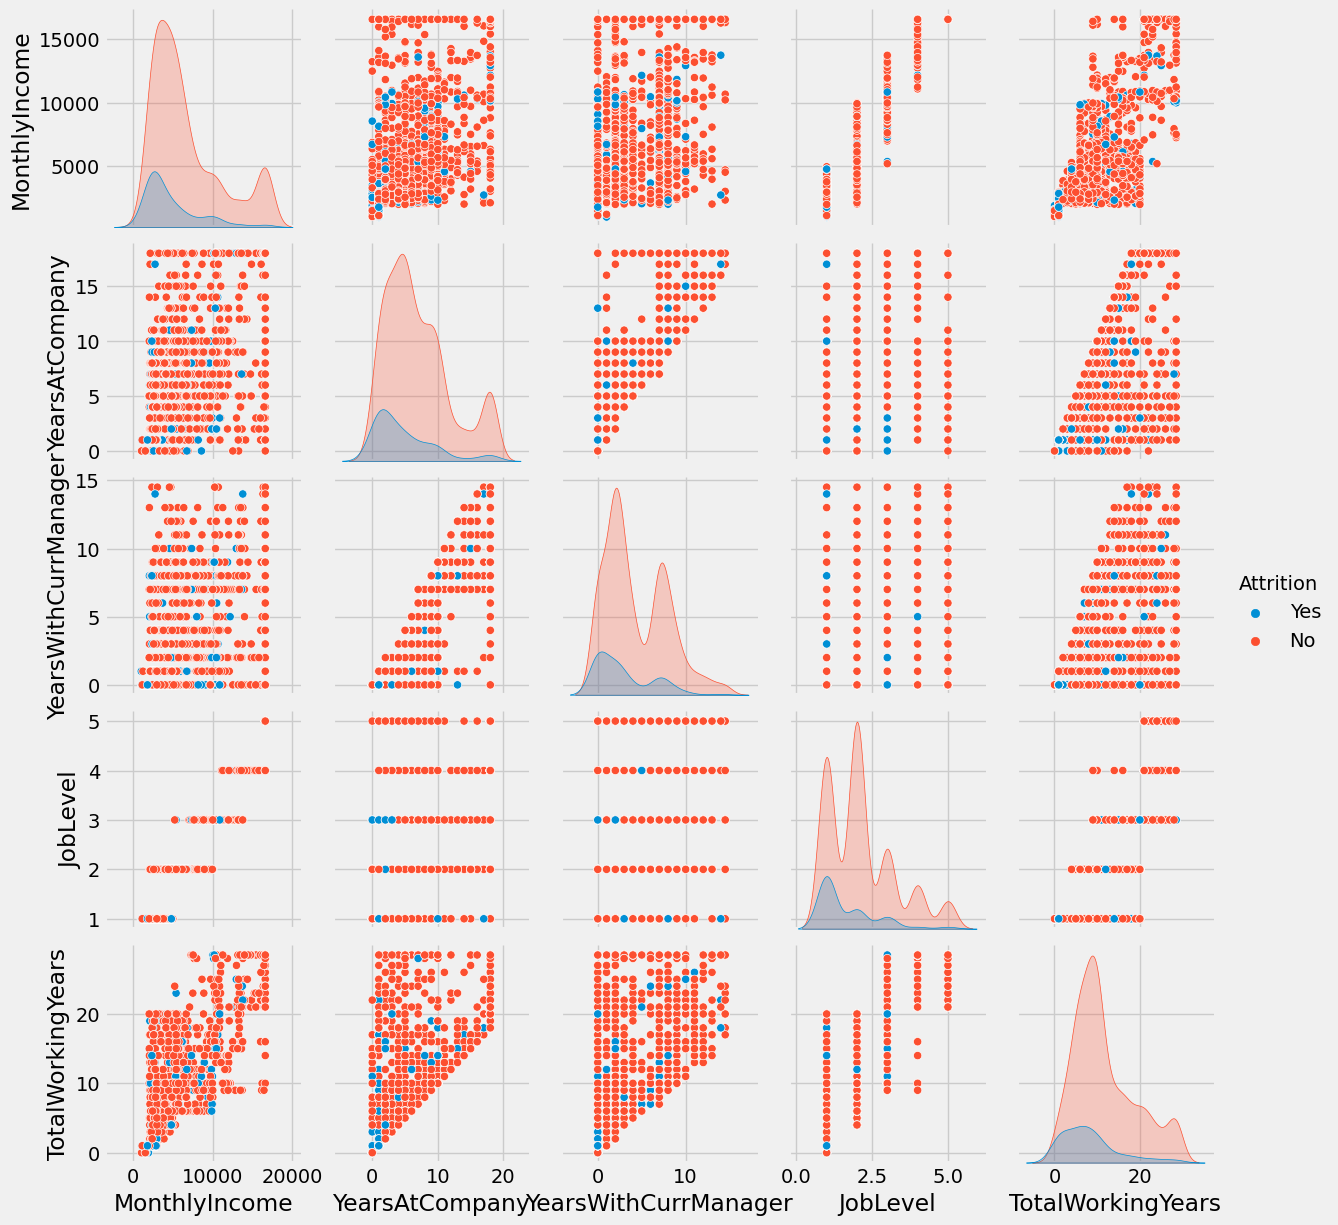

In [ ]:
# Visualize a pirplot with few feature
features = ['MonthlyIncome', 'Attrition', 'YearsAtCompany', 'YearsWithCurrManager', 'JobLevel', 'TotalWorkingYears']
pairplot = sns.pairplot(ibm_df1[features], diag_kind='kde', hue='Attrition')
plt.show()

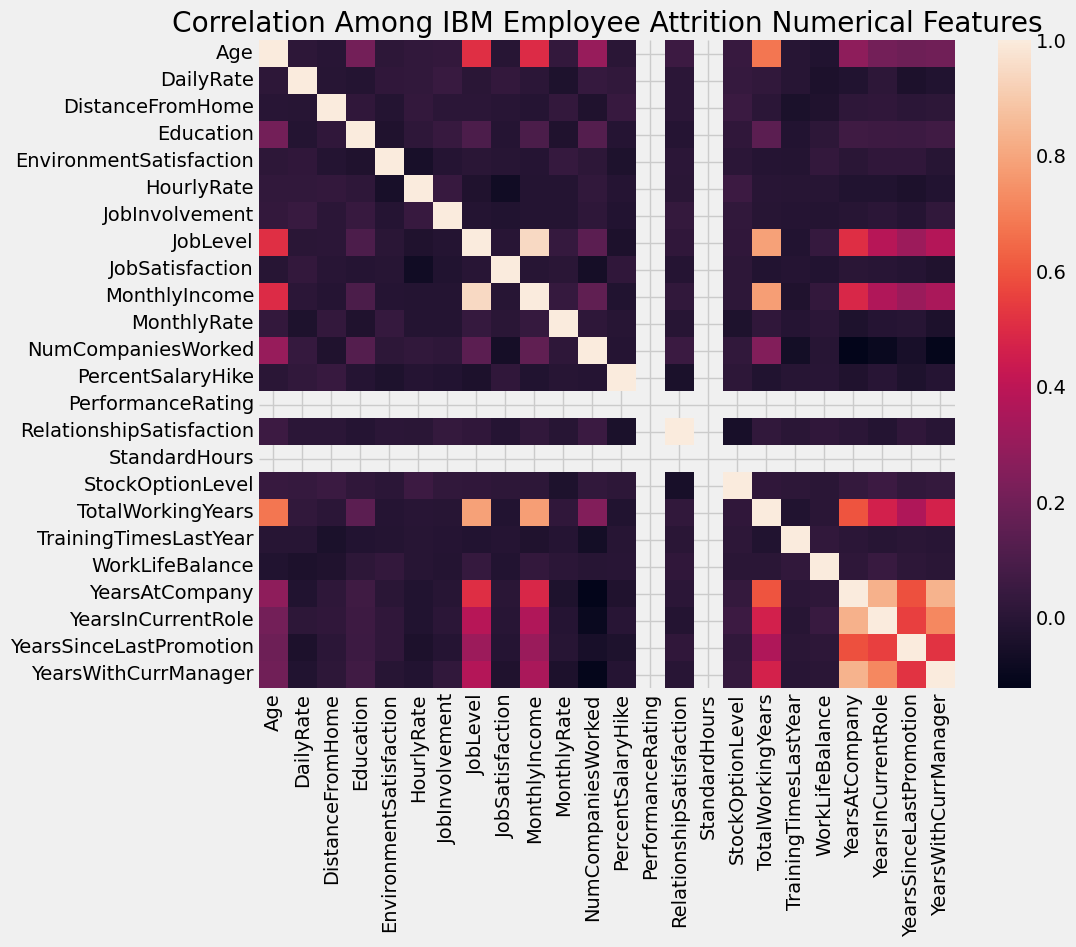

In [ ]:
# Explore Correlation
# Visualize heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(ibm_df1.corr())
plt.title('Correlation Among IBM Employee Attrition Numerical Features')
plt.show()

In [ ]:
# Part-B
# Preparing the Validation Data


In [ ]:
# Split into training and validation set
train_ibm_df, test_ibm_df = train_test_split(ibm_df1, test_size = 0.05, stratify = ibm_df1['Attrition'], random_state = 123)
train_ibm_df.shape, test_ibm_df.shape

((1396, 32), (74, 32))

In [ ]:
print("Attrition train")
print(train_ibm_df['Attrition'].value_counts()/len(train_ibm_df))
print("Attrition test")
print(test_ibm_df['Attrition'].value_counts()/len(test_ibm_df))

Attrition train
No     0.838825
Yes    0.161175
Name: Attrition, dtype: float64
Attrition test
No     0.837838
Yes    0.162162
Name: Attrition, dtype: float64


In [ ]:
test_ibm_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1294,41,No,Travel_Rarely,447,Research & Development,5,3,Life Sciences,2,Male,85,4,2,Healthcare Representative,2,Single,6870,15530,3.0,No,12,3,1,80,0.0,11.0,3.0,1,3,2.0,1.0,2.0
634,25,No,Travel_Rarely,141,Sales,3,1,Other,3,Male,98,3,2,Sales Executive,1,Married,4194,14363,1.0,Yes,18,3,4,80,0.0,5.0,3.0,3,5,3.0,0.0,3.0
60,32,No,Travel_Rarely,427,Research & Development,1,3,Medical,1,Male,33,3,2,Manufacturing Director,4,Married,6162,10877,1.0,Yes,22,3,2,80,1.0,9.0,3.0,3,9,8.0,7.0,8.0
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1.0,Yes,20,3,2,80,1.0,6.0,0.5,3,6,2.0,0.0,3.0
424,57,No,Travel_Rarely,210,Sales,29,3,Marketing,1,Male,56,2,4,Manager,4,Divorced,14118,22102,3.0,No,12,3,3,80,1.0,28.5,3.0,2,1,0.0,0.0,0.0


In [ ]:
categorical

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [ ]:
# Handling categorical features in test set
test_dummy = pd.get_dummies(test_ibm_df[categorical], drop_first=True)
test_dummy.head()

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
1294,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
634,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1
60,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1467,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
424,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Concat encoded features
test_ibm_df = pd.concat([test_ibm_df, test_dummy], axis=1)
# Drop original categorical columns
test_ibm_df.drop(columns = categorical, inplace=True)
test_ibm_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
1294,41,447,5,3,2,85,4,2,2,6870,15530,3.0,12,3,1,80,0.0,11.0,3.0,1,3,2.0,1.0,2.0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
634,25,141,3,1,3,98,3,2,1,4194,14363,1.0,18,3,4,80,0.0,5.0,3.0,3,5,3.0,0.0,3.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1
60,32,427,1,3,1,33,3,2,4,6162,10877,1.0,22,3,2,80,1.0,9.0,3.0,3,9,8.0,7.0,8.0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1467,27,155,4,3,2,87,4,2,2,6142,5174,1.0,20,3,2,80,1.0,6.0,0.5,3,6,2.0,0.0,3.0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
424,57,210,29,3,1,56,2,4,4,14118,22102,3.0,12,3,3,80,1.0,28.5,3.0,2,1,0.0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Rename target column
test_ibm_df.rename(columns={'Attrition_Yes': 'attrition'}, inplace=True)
test_ibm_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,attrition,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
1294,41,447,5,3,2,85,4,2,2,6870,15530,3.0,12,3,1,80,0.0,11.0,3.0,1,3,2.0,1.0,2.0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
634,25,141,3,1,3,98,3,2,1,4194,14363,1.0,18,3,4,80,0.0,5.0,3.0,3,5,3.0,0.0,3.0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1
60,32,427,1,3,1,33,3,2,4,6162,10877,1.0,22,3,2,80,1.0,9.0,3.0,3,9,8.0,7.0,8.0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1
1467,27,155,4,3,2,87,4,2,2,6142,5174,1.0,20,3,2,80,1.0,6.0,0.5,3,6,2.0,0.0,3.0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1
424,57,210,29,3,1,56,2,4,4,14118,22102,3.0,12,3,3,80,1.0,28.5,3.0,2,1,0.0,0.0,0.0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
# Features
test_x = test_ibm_df.drop('attrition', axis=1)
# Targer label
test_y = test_ibm_df['attrition']

test_x.shape, test_y.shape

((74, 45), (74,))

Use Hyperopt, a hyperparameter tuning technique to identify the best set of parameters.

In [ ]:
# Hyperopt (Optional)

def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break

    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    F1 = round(trials[fit_idx]['result']['f1 score'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'f1_score': F1,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In [ ]:
# Data Processing for CatBoost

In [ ]:
cbo_data = train_ibm_df.copy()
cbo_data.shape

(1396, 32)

In [ ]:
# Handling categorical features in train set
cbo_dummy = pd.get_dummies(cbo_data[categorical], drop_first=True)
cbo_dummy.head()

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
cbo_data = pd.concat([cbo_data, cbo_dummy], axis=1)
cbo_data.drop(columns = categorical, inplace=True)
cbo_data.head(5)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Rename target column
cbo_data.rename(columns={'Attrition_Yes': 'attrition'}, inplace=True)
cbo_data.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,attrition,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Features
x_df = cbo_data.drop('attrition', axis=1)
# Targer label
y_df = cbo_data['attrition']

x_df.shape, y_df.shape

((1396, 45), (1396,))

In [ ]:
# SMOTE (Optional)
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

<Axes: ylabel='count'>

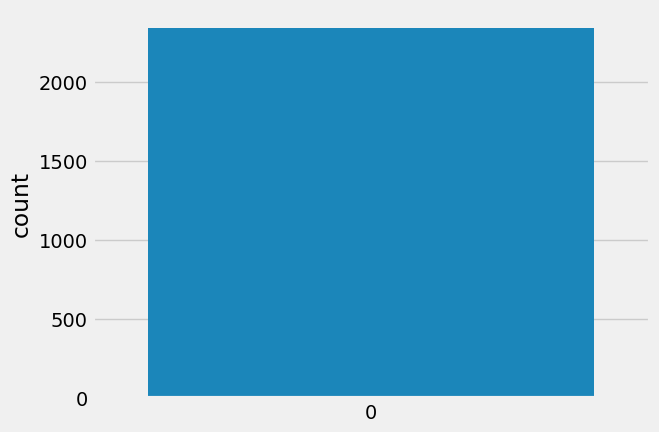

In [ ]:
sns.countplot(y_df1, label = 'count')

* Let's build a CatBoostClassifier.
* Please [Refer here](https://catboost.ai/en/docs/concepts/speed-up-training\) to see some ways to speedup CatBoost training.

In [ ]:



def cat_objective(space):

    cboost = CatBoostClassifier(
    eval_metric  = 'AUC',
    learning_rate = space['learning_rate'],
    iterations = space['iterations'],
    depth = space['depth'],
    l2_leaf_reg = space['l2_leaf_reg'],
    border_count = space['border_count']
    )

    cboost.fit(x_df1, y_df1,
            cat_features=None)

    predictions = cboost.predict(test_x)
    test_preds = cboost.predict_proba(test_x)[:,1]
    train_preds = cboost.predict_proba(x_df1)[:,1]

    train_auc = roc_auc_score(y_df1, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1}

In [ ]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'iterations': hp.quniform('iterations', 25, 1000, 25),
    'depth': hp.quniform('depth', 1, 16, 1),
    'border_count': hp.quniform('border_count', 30, 220, 5),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

cboost_hyperparams = fmin(fn = cat_objective,
                 max_evals = 150,
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
display(cbo_results)

Streaming output truncated to the last 5000 lines.
127:	total: 150ms	remaining: 818ms
128:	total: 152ms	remaining: 817ms
129:	total: 153ms	remaining: 816ms
130:	total: 154ms	remaining: 815ms
131:	total: 155ms	remaining: 814ms
132:	total: 156ms	remaining: 813ms
133:	total: 157ms	remaining: 812ms
134:	total: 159ms	remaining: 811ms
135:	total: 160ms	remaining: 810ms
136:	total: 161ms	remaining: 809ms
137:	total: 163ms	remaining: 810ms
138:	total: 164ms	remaining: 808ms
139:	total: 165ms	remaining: 808ms
140:	total: 166ms	remaining: 808ms
141:	total: 168ms	remaining: 806ms
142:	total: 169ms	remaining: 804ms
143:	total: 170ms	remaining: 803ms
144:	total: 171ms	remaining: 802ms
145:	total: 172ms	remaining: 800ms
146:	total: 173ms	remaining: 799ms
147:	total: 174ms	remaining: 798ms
148:	total: 176ms	remaining: 796ms
149:	total: 177ms	remaining: 795ms
150:	total: 178ms	remaining: 795ms
151:	total: 179ms	remaining: 794ms
152:	total: 180ms	remaining: 792ms
153:	total: 182ms	remaining: 791ms
154:

{'model': 'CatBoost',
 'parameter search time': '0:52:09.702000',
 'accuracy': 0.878,
 'f1_score': 0.526,
 'test auc score': 0.935,
 'training auc score': 0.987,
 'parameters': {'border_count': 210.0,
  'depth': 3.0,
  'iterations': 925.0,
  'l2_leaf_reg': 9.0,
  'learning_rate': 0.016275446269115514}}

In [ ]:
# Create CatBoost model
cboost = CatBoostClassifier(learning_rate = 1,
                            depth = 1,
                            scale_pos_weight = 6,
                            l2_leaf_reg = 8,
                            border_count = 65)

In [ ]:
cboost_dft = CatBoostClassifier()

In [ ]:
cboost_dft.fit(x_df, y_df, cat_features = None)

Learning rate set to 0.01188
0:	learn: 0.6859968	total: 1.68ms	remaining: 1.68s
1:	learn: 0.6765181	total: 4.2ms	remaining: 2.1s
2:	learn: 0.6687945	total: 6.42ms	remaining: 2.13s
3:	learn: 0.6611176	total: 8.56ms	remaining: 2.13s
4:	learn: 0.6535012	total: 10.8ms	remaining: 2.15s
5:	learn: 0.6463303	total: 12.8ms	remaining: 2.12s
6:	learn: 0.6397001	total: 15.1ms	remaining: 2.13s
7:	learn: 0.6314022	total: 17.4ms	remaining: 2.15s
8:	learn: 0.6241989	total: 19.8ms	remaining: 2.18s
9:	learn: 0.6169518	total: 22.2ms	remaining: 2.19s
10:	learn: 0.6110061	total: 24.9ms	remaining: 2.24s
11:	learn: 0.6032202	total: 27.1ms	remaining: 2.23s
12:	learn: 0.5978247	total: 29.3ms	remaining: 2.23s
13:	learn: 0.5913540	total: 31.5ms	remaining: 2.22s
14:	learn: 0.5845327	total: 34ms	remaining: 2.23s
15:	learn: 0.5788628	total: 36.5ms	remaining: 2.25s
16:	learn: 0.5731824	total: 38.8ms	remaining: 2.24s
17:	learn: 0.5670416	total: 41ms	remaining: 2.23s
18:	learn: 0.5616821	total: 43.1ms	remaining: 2.23s

In [ ]:
# Hyperopt, hyperparameter tuning technique was used to idetify the best set of parameters.

# Different set of hyperparameters were giving good result.
# Out of them, one such set was chosen.

In [ ]:
# Model training
cboost.fit(x_df, y_df, cat_features = None)

0:	learn: 0.6545709	total: 893us	remaining: 893ms
1:	learn: 0.6137232	total: 2.19ms	remaining: 1.09s
2:	learn: 0.5981307	total: 3.24ms	remaining: 1.07s
3:	learn: 0.5894097	total: 4.23ms	remaining: 1.05s
4:	learn: 0.5705610	total: 5.78ms	remaining: 1.15s
5:	learn: 0.5486329	total: 6.98ms	remaining: 1.16s
6:	learn: 0.5321533	total: 8.13ms	remaining: 1.15s
7:	learn: 0.5237833	total: 9.24ms	remaining: 1.15s
8:	learn: 0.5184546	total: 10.3ms	remaining: 1.13s
9:	learn: 0.5091409	total: 11.4ms	remaining: 1.13s
10:	learn: 0.5008417	total: 12.7ms	remaining: 1.14s
11:	learn: 0.4928863	total: 13.8ms	remaining: 1.13s
12:	learn: 0.4855013	total: 14.9ms	remaining: 1.13s
13:	learn: 0.4796769	total: 15.9ms	remaining: 1.12s
14:	learn: 0.4739011	total: 17.1ms	remaining: 1.12s
15:	learn: 0.4694276	total: 18.1ms	remaining: 1.11s
16:	learn: 0.4654488	total: 19.1ms	remaining: 1.1s
17:	learn: 0.4616108	total: 20.1ms	remaining: 1.09s
18:	learn: 0.4584340	total: 21ms	remaining: 1.08s
19:	learn: 0.4537152	total

In [ ]:
# Model performance on all sets
predictions = cboost.predict(test_x)
test_preds = cboost.predict_proba(test_x)[:,1]
train_preds = cboost.predict_proba(x_df)[:,1]

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

In [ ]:
F1 = f1_score(test_y, predictions)
print(F1)

0.6153846153846153


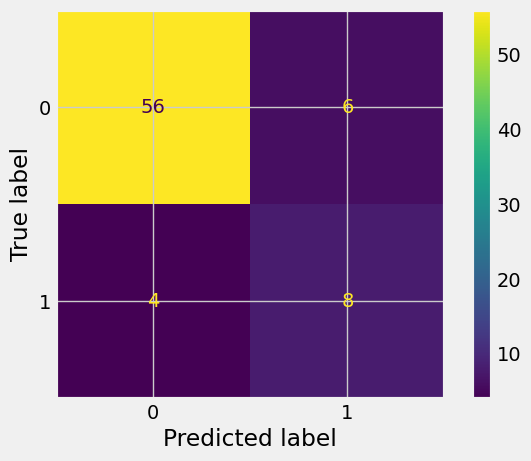

In [ ]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

In [ ]:
# Feature Importance (Optional)
features = x_df.columns
importances_cboost = cboost.feature_importances_

In [ ]:
cboost_results = {'accuracy': accuracy,
                  'model': 'CatBoost',
                  'f1_score': F1,
                  'training auc score': train_auc,
                  'test auc score': test_auc}
cboost_results

{'accuracy': 0.8648648648648649,
 'model': 'CatBoost',
 'f1_score': 0.6153846153846153,
 'training auc score': 0.9804649397476042,
 'test auc score': 0.8844086021505376}

In [ ]:
# After removing those features.

# f1 score fell below from 51 to 45.
# Overfitting reduced.
# K-fold cross validation (Optional)
# To use K-fold cross validation, training data file can be split into train and test sets using train_test_split method.

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
for k, (train, test) in enumerate(kfold.split(x_df, y_df)):
    cboost.fit(x_df.iloc[train], y_df.iloc[train])
    print(f'iteration number = {k+1}')
    print(f'Training Accuracy = {cboost.score(x_df.iloc[train], y_df.iloc[train])}')
    print(f'Test Accuracy = {cboost.score(x_df.iloc[test], y_df.iloc[test])}')
    print(f'f1 score = {f1_score(test_y, predictions)}')

Streaming output truncated to the last 5000 lines.
20:	learn: 0.4443004	total: 21.6ms	remaining: 1s
21:	learn: 0.4406628	total: 22.6ms	remaining: 1s
22:	learn: 0.4370582	total: 23.5ms	remaining: 999ms
23:	learn: 0.4337110	total: 25.1ms	remaining: 1.02s
24:	learn: 0.4306616	total: 26.4ms	remaining: 1.03s
25:	learn: 0.4280173	total: 27.4ms	remaining: 1.03s
26:	learn: 0.4254835	total: 29ms	remaining: 1.04s
27:	learn: 0.4220124	total: 30.3ms	remaining: 1.05s
28:	learn: 0.4181031	total: 31.3ms	remaining: 1.05s
29:	learn: 0.4154124	total: 32.8ms	remaining: 1.06s
30:	learn: 0.4127288	total: 35ms	remaining: 1.09s
31:	learn: 0.4092558	total: 37.4ms	remaining: 1.13s
32:	learn: 0.4067069	total: 38.4ms	remaining: 1.13s
33:	learn: 0.4047481	total: 39.5ms	remaining: 1.12s
34:	learn: 0.4031424	total: 40.5ms	remaining: 1.12s
35:	learn: 0.4007312	total: 41.5ms	remaining: 1.11s
36:	learn: 0.3993072	total: 42.5ms	remaining: 1.1s
37:	learn: 0.3973715	total: 43.5ms	remaining: 1.1s
38:	learn: 0.3955113	tota

In [ ]:
# Data Processing for XGBoost
# Exercise 10: Data Processing for XGBoost [1 Mark]

# Copy the dataframe after the outliers were removed.
# Handle the categorical features if required
# Create target column and feature space

In [ ]:
# Copy dataframe
xgb_data = train_ibm_df.copy()

In [ ]:
# Handling categorical features
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)
xgb_dummy.head()

,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
xgb_data = pd.concat([xgb_data, xgb_dummy], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.head(5)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Rename target column
xgb_data.rename(columns={'Attrition_Yes': 'attrition'}, inplace=True)
xgb_data.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,attrition,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Features
x_df = xgb_data.drop('attrition', axis=1)
# Targer label
y_df = xgb_data['attrition']

x_df.shape, y_df.shape

((1396, 45), (1396,))

In [ ]:
x_df.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
216,30,334,26,4,3,52,2,2,1,6696,22967,5.0,15,3,3,80,0.0,9.0,4.5,2,6,3.0,0.0,1.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
623,30,1012,5,4,2,75,2,1,4,3761,2373,8.5,12,3,2,80,1.0,10.0,3.0,2,5,4.0,0.0,3.0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
109,22,534,15,3,2,59,3,1,4,2871,23785,1.0,15,3,3,80,0.0,1.0,4.5,3,0,0.0,0.0,0.0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1240,39,792,1,3,4,77,3,2,4,6472,8989,1.0,15,3,4,80,1.0,9.0,2.0,3,9,8.0,5.0,8.0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1
1442,29,1092,1,4,1,36,3,1,4,4787,26124,8.5,14,3,2,80,2.5,4.0,3.0,4,2,2.0,2.0,2.0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1


In [ ]:
# Unlike LightGBM, in XGB, one has to manually create dummy variable/ label encoding for categorical features before feeding them into the models

In [ ]:
# SMOTE (Optional)

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)

<Axes: ylabel='count'>

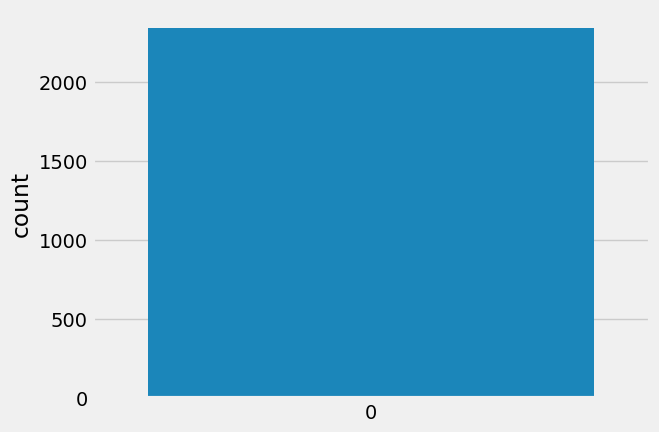

In [ ]:
sns.countplot(y_df1, label = 'count')

In [ ]:
# Model Definition
# Exercise 11: Define, train the model and display the results [2 Mark]

In [ ]:
def xgb_objective(space):

    model = XGBClassifier(
        learning_rate = space['learning_rate'],
        n_estimators = int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        min_child_weight = space['m_child_weight'],
        gamma = space['gamma'],
        subsample = space['subsample'],
        scale_pos_weight = 6,
        colsample_bytree = space['colsample_bytree'],
        objective = 'binary:logistic'
    )

    model.fit(x_df, y_df)

    predictions = model.predict(test_x)
    test_preds = model.predict_proba(test_x)[:,1]
    train_preds = model.predict_proba(x_df)[:,1]

    xgb_booster = model.get_booster()
    train_auc = roc_auc_score(y_df, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1
           }

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

In [ ]:
trials = Trials()

In [ ]:
# xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
# display(xgb_results)

In [ ]:
# Create XGBoost classifier model
xgb_model = XGBClassifier(
    learning_rate = 0.14972574734435318,
    n_estimators = 200,
    max_depth = 1,
    min_child_weight = 6,
    gamma = 0.5,
    subsample = 0.55,
    colsample_bytree = 1,
    scale_pos_weight = 6,
    objective = 'binary:logistic'
)

In [ ]:
x_df.shape, y_df.shape

((1396, 45), (1396,))

In [ ]:
xgb_model.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14972574734435318, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_model_dft = XGBClassifier()

In [ ]:
xgb_model_dft.fit(x_df, y_df)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Model performance on all sets
predictions = xgb_model.predict(test_x)
test_preds = xgb_model.predict_proba(test_x)[:,1]
train_preds = xgb_model.predict_proba(x_df)[:,1]

xgb_booster = xgb_model.get_booster()

train_auc = roc_auc_score(y_df, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

In [ ]:
F1 = f1_score(test_y, predictions)
print(F1)

0.6470588235294118


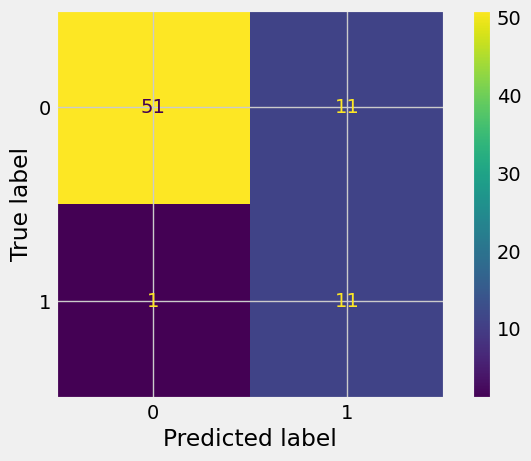

In [ ]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

In [ ]:
features = x_df.columns
importances_xgboost = xgb_model.feature_importances_

In [ ]:
xgb_results = {'accuracy': accuracy,
              'model': 'XGBoost',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}
xgb_results

{'accuracy': 0.8378378378378378,
 'model': 'XGBoost',
 'f1_score': 0.6470588235294118,
 'test auc score': 0.9448924731182795,
 'training auc score': 0.9072663440554132}

f1 score fell below, from 51 to 50. But, Overfitting is unaffected. Let's try LightGBM Model.

* LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM.
* By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).
* To know more about LightGBM parameters, [refer here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

In [ ]:
### Feature Engineering for LightGBM

In [ ]:
lgb_data.columns

Index(['Attrition_Yes', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Research & Development',
       'Department_Sales', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Male', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'OverTime_Yes', 'Age', 'DailyRate',
       'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'Stock

In [ ]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
lgb_data = train_ibm_df.copy()

# Handling categorical features
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)

# Concat the dummy variables to actual dataframe and remove initial categorical columns
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)

# Rename target column
lgb_data.rename(columns={'Attrition_Yes': 'attrition'}, inplace=True)

# Features
x_df = lgb_data.drop(columns='attrition')
# Target lebel
y_df = lgb_data['attrition'].reset_index(drop=True)
x_df.shape, y_df.shape

((1396, 45), (1396,))

**SMOTE sampling:** We'll use SMOTE sampling method to handle imbalance dataset.


<Axes: ylabel='count'>

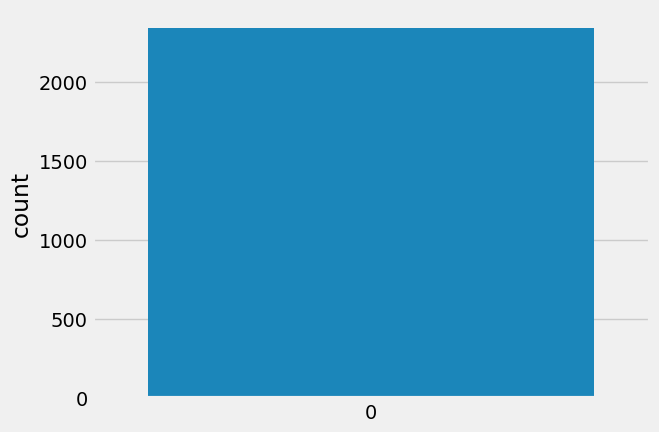

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
x_df1, y_df1 = oversample.fit_resample(x_df, y_df)
sns.countplot(y_df1, label = 'count')

In [ ]:
# Model Definition

def lgb_objective(space):

    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']),
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        scale_pos_weight = 5,
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain']
    )

    lgbm.fit(x_df, y_df)

    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(x_df)[:,1]

    train_auc = roc_auc_score(y_df, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    F1 = f1_score(test_y, predictions)

    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc, 'f1 score': F1

           }

In [ ]:
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective,
                 max_evals = 150,
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

{'model': 'LightGBM',
 'parameter search time': '0:12:21.810000',
 'accuracy': 0.838,
 'f1_score': 0.0,
 'test auc score': 0.772,
 'training auc score': 0.955,
 'parameters': {'colsample_bytree': 0.6771640602328538,
  'feature_fraction': 0.8674335678754975,
  'learning_rate': 0.0014085542174767302,
  'max_depth': 7.0,
  'min_split_gain': 0.03398971656902088,
  'n_estimators': 125.0,
  'num_leaves': 42.0,
  'reg_alpha': 0.685270613292968,
  'reg_lambda': 0.04249323579997062}}

In [ ]:
# Create LightGBM classifier model
lgbm = LGBMClassifier(
    learning_rate = 0.15828893812295405,
    n_estimators= 825,
    max_depth = 8,
    num_leaves = 110,
    colsample_bytree = 0.6839759118900923,
    feature_fraction = 0.3930665137463929,
    reg_lambda = 0.8857198279892347,
    reg_alpha = 0.8003856547872137,
    min_split_gain = 0.07737786522996747
)

In [ ]:
# Create LightGBM classifier model
lgbm = LGBMClassifier(
    learning_rate = 1,
    n_estimators= 100,
    max_depth = 3,
    num_leaves = 31,
    colsample_bytree = 1,
    reg_lambda = 30,
    scale_pos_weight = 5,
    reg_alpha = 30,
    min_split_gain = 3
)

In [ ]:
lgbm.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 1171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649513
[LightGBM] [Info] Start training from score -1.649513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

LGBMClassifier(colsample_bytree=1, learning_rate=1, max_depth=3,
               min_split_gain=3, reg_alpha=30, reg_lambda=30,
               scale_pos_weight=5)

In [ ]:
lgbm_dft = LGBMClassifier()

In [ ]:
lgbm_dft.fit(x_df, y_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225, number of negative: 1171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 1396, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649513
[LightGBM] [Info] Start training from score -1.649513


LGBMClassifier()

In [ ]:
# Model performance on all sets
predictions = lgbm.predict(test_x)
test_preds = lgbm.predict_proba(test_x)[:,1]
train_preds = lgbm.predict_proba(x_df1)[:,1]

train_auc = roc_auc_score(y_df1, train_preds)
test_auc = roc_auc_score(test_y, test_preds)
accuracy = accuracy_score(test_y, predictions)

In [ ]:
F1 = f1_score(test_y, predictions)
print(F1)

0.27906976744186046


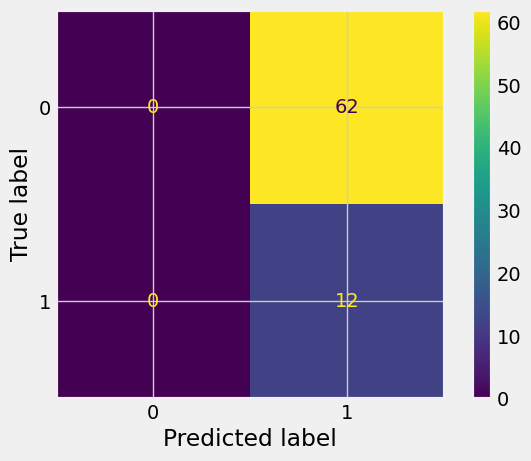

In [ ]:
cm = confusion_matrix(test_y, predictions, labels=cboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cboost.classes_)
disp.plot()
plt.show()

In [ ]:
# Feature Importance

features = x_df.columns
importances_lgbm = lgbm.feature_importances_

In [ ]:
lgbm_results = {'accuracy': accuracy,
              'model': 'LightGBM',
              'f1_score': F1,
              'test auc score': test_auc,
              'training auc score': train_auc}

lgbm_results

{'accuracy': 0.16216216216216217,
 'model': 'LightGBM',
 'f1_score': 0.27906976744186046,
 'test auc score': 0.3064516129032258,
 'training auc score': 0.7455622315843823}

In [ ]:
# f1 score drastically fell.

# Overfiiting is unaffected.

In [ ]:
# Importances Dataframe
importances_cboost

array([7.67273853, 9.02456938, 3.38852629, 0.11750302, 3.29953302,
       5.88569465, 2.50502377, 5.60527495, 2.29552299, 8.43645154,
       6.37030637, 2.16996699, 2.74905082, 0.        , 1.69144306,
       0.        , 4.27009453, 2.25703515, 1.08730227, 1.40120466,
       2.51708016, 2.36745326, 1.74767643, 5.63502807, 2.0876631 ,
       0.63088038, 2.9265668 , 0.15873884, 0.13048199, 0.17604423,
       0.02736759, 0.        , 0.93438973, 0.45934451, 0.27976257,
       0.79721333, 0.        , 0.18863242, 0.40082477, 0.75143236,
       0.01587939, 0.10743704, 0.25571134, 0.28036818, 6.8967815 ])

In [ ]:
print(np.round(importances_xgboost*100))

[4. 2. 2. 1. 3. 2. 3. 3. 3. 3. 2. 3. 2. 0. 2. 0. 7. 3. 2. 2. 2. 3. 3. 4.
 3. 2. 3. 3. 3. 0. 0. 0. 2. 2. 0. 2. 0. 0. 2. 3. 0. 5. 0. 2. 5.]


In [ ]:
importances_lgbm

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
       1, 1, 0, 2, 0, 1, 0, 3, 1, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 2, 1, 0,
       1], dtype=int32)

In [ ]:
print(np.round(importances_cboost))

[8. 9. 3. 0. 3. 6. 3. 6. 2. 8. 6. 2. 3. 0. 2. 0. 4. 2. 1. 1. 3. 2. 2. 6.
 2. 1. 3. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 7.]


In [ ]:
importances_df = pd.DataFrame()
importances_df['Feature Name'] = features
importances_df['Feature Imp CBoost'] = np.round(importances_cboost)
importances_df['Feature Imp XGBoost'] = np.round(importances_xgboost*100)
importances_df['Feature Imp LightBoost'] = importances_lgbm
importances_df.sort_values(['Feature Imp CBoost', 'Feature Imp XGBoost', 'Feature Imp LightBoost'], ascending=False)

,Feature Name,Feature Imp CBoost,Feature Imp XGBoost,Feature Imp LightBoost
1,BusinessTravel_Travel_Rarely,9.0,2.0,0
0,BusinessTravel_Travel_Frequently,8.0,4.0,1
9,Gender_Male,8.0,3.0,0
44,YearsWithCurrManager,7.0,5.0,1
23,DistanceFromHome,6.0,4.0,1
7,EducationField_Other,6.0,3.0,0
5,EducationField_Marketing,6.0,2.0,0
10,JobRole_Human Resources,6.0,2.0,0
16,JobRole_Sales Executive,4.0,7.0,0
4,EducationField_Life Sciences,3.0,3.0,0


In [ ]:
# Results
# Exercise 12: Create a dataframe of XGBoost results, LightGBM results, CatBoost results and display them [0.5 Mark]

In [ ]:
# Create a dataframe for computed metrics for different models
final_results = pd.DataFrame([xgb_results, lgbm_results, cboost_results])
display(final_results)

,accuracy,model,f1_score,test auc score,training auc score
0,0.837838,XGBoost,0.647059,0.944892,0.907266
1,0.162162,LightGBM,0.279070,0.306452,0.745562
2,0.864865,CatBoost,0.615385,0.884409,0.980465


Few of the observations from our experiment are as follows-

* XGBoost is a wonderful algorithm with great documentation and many examples from years of use.

* LightGBM was clearly the fastest algorithm, often being 10x faster than XGBoost.

* In terms of accuracy the test and train dataset often had different balances of minority and majority class so 1-to-1 comparisons aren't perfect.

* CatBoost was the algorithm one can be most interested in using because of the supposed innovations in working with categorical data. Despite good accuracy however, several problems were faced.

* CatBoost seemed significantly slower than the other algorithms, it seemed to stall on some evaluations. More experimentation may be needed with CatBoost and data that had lots of categorical features to get a better feel for when it may perform best.

* SMOTE was used to handle imabalance, it had no effect on the performance of all the three models.

* Using POS weight parameter to handle imabalace in all the three models helps give good results.

* K-fold cross validation technique was used while using train test split, performance of the model dipped.

* Outliers were handled but it had least effect on the performance.

* Three irrelevant features were dropped, it had no effect on the model performance.

* By far CatBoost is the best performing model followed by XGBoost whereas CatBoost takes longer to optimize parameters using Hyperopt, it is quick with XGBoost.

* Feature importance was calculated for all the three models.

* Based upon the importance 5 features were identified as not important. Removing these features while training dipped the performance of the models.

